# Loan Completion Analysis
## by Jeff Mitchell

## Investigation Overview

The purpose of this analysis is to see what factors impact on the likelihood of a loan being completed. The main focus was on Loan completion and specific factors of the member and the loan that influenced loan completion.

## Dataset Overview

The dataset contains information on nearly 114,000 loans from Prosper. Only loans that had been conclcuded (Paid off succesfully or failed to be paid off) were used for the analysis, which reduced the sample number to 55076. There were loans that were missing values that could not be corrected which resulted in a further 591 loans being removed.

Attributes of interest included Loan completion status, BorrowerAPR, Debt-to-income ratio, Term, Loan Origination Quarter, Monthly Loan Payments and Employment status. There were 81 data points per loan, many of which were not relevant for this analysis. This number was reduced to 16 for the intial analysis.

In [1]:
# import all packages and set plots to be embedded inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb

%matplotlib inline

# suppress warnings from final output
import warnings
warnings.simplefilter("ignore")

In [2]:
# load in the dataset into a pandas dataframe
loans = pd.read_csv('prosperLoanData.csv')

In [3]:
# prepare the data prior to analysis

# reduce the number of columns to just those that are of interest
columns = ['Term', 'LoanStatus', 'BorrowerAPR', 'ListingCategory (numeric)', 'EmploymentStatus', 'IsBorrowerHomeowner', 
           'CreditScoreRangeLower', 'CreditScoreRangeUpper', 'DebtToIncomeRatio', 'StatedMonthlyIncome', 'LoanNumber',
           'LoanOriginalAmount', 'LoanOriginationQuarter', 'MemberKey', 'MonthlyLoanPayment']
loans = loans[columns]

# rename columns
loans = loans.rename(columns={'ListingCategory (numeric)':'ListingCategory','IsBorrowerHomeowner':'HomeOwner',})

# remove loans that have not reached an outcome
loans = loans[loans['LoanStatus'].isin(['Completed', 'Chargedoff', 'Defaulted', 'Cancelled'])]

# drop rows duplicated on LoanNumber
loans.drop_duplicates('LoanNumber', inplace=True)

In [4]:
# create LoanCompleted column

# Function to return loan completion status
def getLoanCompleted(loan_status):
    """Return 'Completed' if loan completed, 'Not completed' otherwise."""
    if loan_status.strip() == 'Completed':
        return 'Completed'
    else:
        return 'Not completed'
    
# Create column to hold status of loan outcome
loans['LoanCompleted'] = loans['LoanStatus'].apply(getLoanCompleted)
loans['LoanCompleted'] = loans['LoanCompleted'].astype('category')

# Drop LoanStatus column
loans.drop('LoanStatus', axis=1, inplace=True)

In [5]:
# convert column types

# Convert LoanNumber to a string as I will not perform calcluations on it
loans['LoanNumber'] = loans['LoanNumber'].astype('str')

# Convert the ListingCategory column to readable values
def convert_listing_category(cat):
    """Convert the listing category to a human-readable string."""
    categories = ['Not Available', 'Debt Consolidation', 'Home Improvement', 'Business', 'Personal Loan', 'Student Use',
                 'Auto', 'Other', 'Baby and Adoption', 'Boat', 'Cosmetic Procedure', 'Engagement Ring', 'Green Loans',
                 'Household Expenses', 'Large Purchases', 'Medical and Dental', 'Motorcycle', 'RV', 'Taxes', 'Vacation',
                 'Wedding']
    return categories[cat]

loans['ListingCategory'] = loans['ListingCategory'].apply(convert_listing_category)

# Convert ListingCategory to categorical types
loans['ListingCategory'] = loans['ListingCategory'].astype('category')

# Convert null EmploymentStatus to 'Not available'
loans['EmploymentStatus'] = loans['EmploymentStatus'].fillna('Not available')

# Convert 'Employed' to 'Full-time'
mask = loans['EmploymentStatus'] == 'Employed'
column_name = 'EmploymentStatus'
loans.loc[mask, column_name] = 'Full-time'

# Convert EmploymentStatus to categorical type
loans['EmploymentStatus'] = loans['EmploymentStatus'].astype('category')

# Convert LoanOriginationQuarter to categorical type
loans['LoanOriginationQuarter'] = loans['LoanOriginationQuarter'].astype('category')

# Convert Term to categorical type
loans['Term'] = loans['Term'].astype('category')

# Function to calculate mean of lower and upper credit ratings
def get_rating(lower, upper):
    "Calculate mean of lower and upper credit ratings."
    mean = (lower + upper) / 2
    return mean

# Add CreditScore column and populate
loans['CreditScore'] = loans.apply(lambda x: get_rating(x['CreditScoreRangeLower'], x['CreditScoreRangeUpper']), axis=1)

# Drop unneeded Credit Range columns
loans.drop(['CreditScoreRangeLower','CreditScoreRangeUpper'], axis=1, inplace=True)

# Fill missing BorrowerAPR values with the mean for the column
mean_apr = loans.BorrowerAPR.mean()
loans['BorrowerAPR'] = loans.BorrowerAPR.fillna(mean_apr)

# Drop rows missing credit values
loans = loans[loans['CreditScore'].isnull() == False]

## Overall Completion Rate

For this analysis loans that were no longer current were included in the analysis subset. This included loans that had been paid off ('Completed') and those that were not paid off ('Not completed'). Overall the completion rate was 69%.

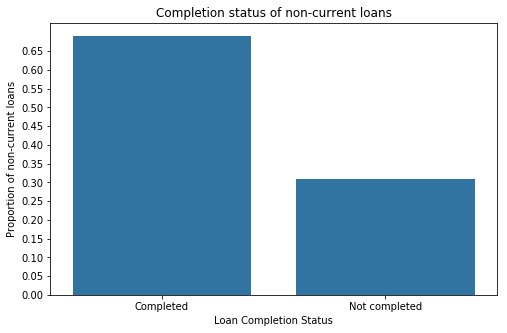

In [48]:
# Plot LoanCompleted column as %
base_color = sb.color_palette()[0]
n_points = loans.shape[0]
max_count = loans['LoanCompleted'].value_counts().max()
max_prop = max_count / n_points
tick_props = np.arange(0, max_prop, 0.05)
tick_names = ['{:0.2f}'.format(v) for v in tick_props]

plt.figure(figsize=[8, 5])
sb.countplot(data = loans, x = 'LoanCompleted', color = base_color)
plt.yticks(tick_props * n_points, tick_names)
plt.ylabel('Proportion of non-current loans')
plt.xlabel('Loan Completion Status')
plt.title('Completion status of non-current loans')
plt.show();

## (Visualization 2)

> You should have at least three visualizations in your presentation,
but feel free to add more if you'd like!

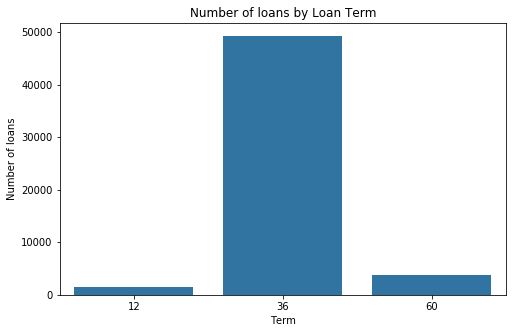

In [51]:
plt.figure(figsize=[8, 5])
sb.countplot(data = loans, x = 'Term', color = base_color)
plt.xlabel('Term')
plt.ylabel('Number of loans')
plt.title('Number of loans by Loan Term')
plt.show();

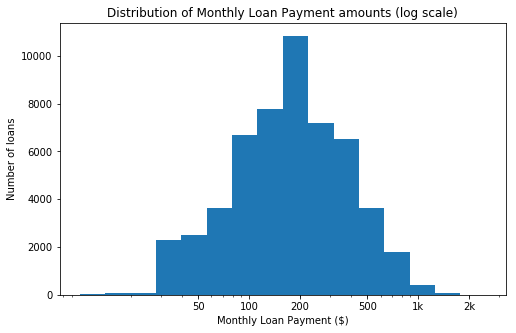

In [54]:
log_binsize = 0.15
bins = 10 ** np.arange(1, np.log10(loans['MonthlyLoanPayment'].max())+log_binsize, log_binsize)

plt.figure(figsize=[8, 5])
plt.hist(data = loans, x = 'MonthlyLoanPayment', bins = bins)
plt.xscale('log')
plt.xticks([50, 100, 200, 500, 1000, 2000], [50, 100, 200, 500, '1k', '2k'])
plt.xlabel('Monthly Loan Payment ($)')
plt.ylabel('Number of loans')
plt.title('Distribution of Monthly Loan Payment amounts (log scale)')

plt.show()

In [43]:
# remove outliers before plotting debt-to-income graph
outliers = loans['DebtToIncomeRatio'] > 9.5
without_outliers = loans.loc[-outliers,:]

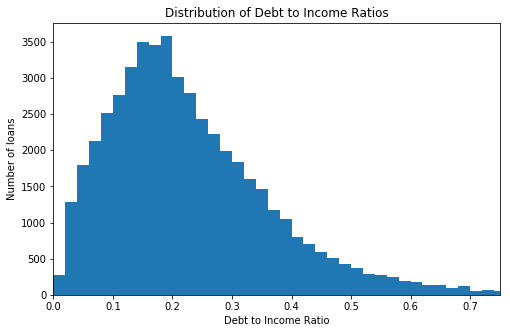

In [44]:
binsize = 0.02
bins = np.arange(0, without_outliers['DebtToIncomeRatio'].max()+binsize, binsize)

plt.figure(figsize=[8, 5])
plt.hist(data = without_outliers, x = 'DebtToIncomeRatio', bins = bins)
plt.xlabel('Debt to Income Ratio')
plt.ylabel('Number of loans')
plt.title('Distribution of Debt to Income Ratios')
plt.xlim(0,0.75)
plt.show()

## (Visualization 3)



> Once you're ready to finish your presentation, check your output by using
nbconvert to export the notebook and set up a server for the slides. From the
terminal or command line, use the following expression:
> > `jupyter nbconvert <file_name>.ipynb --to slides --post serve --template output_toggle`

> This should open a tab in your web browser where you can scroll through your
presentation. Sub-slides can be accessed by pressing 'down' when viewing its parent
slide. Make sure you remove all of the quote-formatted guide notes like this one
before you finish your presentation!